In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.set_option('display.max_columns',100)
pd.set_option('display.precision',5)

tf.random.set_seed(26)

# Creating tensorflow model (8 hiddenlayers, 60 neurons per layer as default parameters)
def init_model(input_size,output_size,num_hiddenlayers=8,num_neurons_perlayer=60,act_fn='selu'):
  # initialising the model and adding the input layer.
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(input_size))

  # Adding the hidden layers
  for i in range(num_hiddenlayers):
    model.add(tf.keras.layers.Dense(num_hiddenlayers,activation=act_fn,kernel_initializer='lecun_normal'))
  
  # Adding the output layer
  model.add(tf.keras.layers.Dense(output_size,activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

# Function to train the model and return trained model and its history
def train_model(model,train_x,train_y,test_x,test_y,n_epochs=10):
  history = model.fit(train_x,train_y,epochs=n_epochs,validation_data=(test_x,test_y))
  test_loss, test_acc = model.evaluate(test_x, test_y, verbose=1) 

  print('Test accuracy:', test_acc)
  return model, history

# Function for One-Hot-Encoding
# Function takes input as the dataframe and column to be onehotencoded
def onc(df,column):
  # First fill nan values with 'others'
  df[column] = df[column].fillna('others')

  # n stores the number of unique entries including the 'others' entry
  n = df[column].nunique()

  # We use the inbuilt OneHotEncoder for encoding
  from sklearn.preprocessing import OneHotEncoder
  enc = OneHotEncoder(sparse=False)

  # separate the column from dataframe and transform it to n different columns
  df_col = np.array(df[column]).reshape(-1,1)
  df_col = enc.fit_transform(df_col)

  #this part names the columns
  name_dir = []
  for i in range(n):
    name_dir.append(column + str(i))
  df_col = pd.DataFrame(df_col,columns=name_dir)

  # Now we join the column to the original dataframe
  df = df.join(df_col)
  # And we dropped the previous column
  df.drop(column,axis=1,inplace=True)
  return df

# Function for binary encoding(0,1)
def bienc(df,column):
  # We use the inbuilt LabelEncoder 
  from sklearn.preprocessing import LabelEncoder
  enc = LabelEncoder()

  # We separate the column from the original dataframe and transform it.
  df_col = np.array(df[column]).reshape(-1,1)
  df_col = enc.fit_transform(df_col)
  df_col = pd.DataFrame(df_col,columns=[column])

  # Here we remove the original column and join the transformed column to dataframe
  df.drop(column,axis=1,inplace=True)
  df = df.join(df_col)
  
  return df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
# Read the csv file
df = pd.read_csv('/content/drive/MyDrive/train_indessa.csv')

# Columns to be one-hot-encoded
oncs = ['verification_status']

# Columns to be binary-encoded
biencs = ['initial_list_status','term']

# Columns to be dropped
drops = ['inq_last_6mths','revol_util','home_ownership','desc','grade','title','zip_code','addr_state','batch_enrolled','member_id','emp_title','verification_status_joint','purpose','emp_length',
         'funded_amnt_inv','loan_amnt','mths_since_last_major_derog','mths_since_last_delinq','mths_since_last_record','pymnt_plan','application_type']

# OneHotEncoding columns
for col in oncs:
  df = onc(df,col)

# Dropping columns
df.drop(drops,axis=1,inplace=True)

# Binary Encoding Columns
for col in biencs:
  df = bienc(df,col)

# Handling the grades and sub-grades column
grades = list(df['sub_grade'].unique())
dir = {}
for grade in grades:
  int_part = ord(grade[0])-64
  dec_part = 0.2*(int(grade[1])-1)
  dir[grade] = int_part + dec_part
for grade in grades:
  df.loc[df['sub_grade']==grade,'sub_grade'] = dir[grade]


# Handling the last_week_pay column
weeks = list(df['last_week_pay'].unique())
dir = {}
for week in weeks:
  wl = week.split('t')
  if(wl[0]=='NA'):
    dir[week] = np.nan
  else:
    dir[week] = int(wl[0])
for week in weeks:
  df.loc[df['last_week_pay']==week,'last_week_pay'] = dir[week]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filling the NaN values with the column mean values
df[df.columns] = df[df.columns].fillna(df[df.columns].mean())

# Scaling the numeric data with StandardScaler.
scaler = StandardScaler()
cont_features = ['funded_amnt','int_rate','annual_inc','dti','delinq_2yrs',
              'open_acc','pub_rec','revol_bal','total_acc','total_rec_int','total_rec_late_fee','recoveries',
                 'collection_recovery_fee','collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal',
                 'total_rev_hi_lim']
df[cont_features] = scaler.fit_transform(df[cont_features])

# Splitting the data into 3 sets: 
# Training set - 70 % records
# Cross-validation set- 15 % records
# Test-set - 15% records.
train_x, rem_x = train_test_split(df,test_size=0.3,random_state=26,stratify =df['loan_status'])
cv_x, test_x = train_test_split(rem_x,test_size=0.5,random_state=26,stratify=rem_x['loan_status'])

# Separating the target variable from each set
train_y = train_x.pop('loan_status')
cv_y = cv_x.pop('loan_status')
test_y = test_x.pop('loan_status')

In [70]:
# Training the first 120 epochs
model = init_model(train_x.shape[1],2,8,50)
model,history = train_model(model,train_x,train_y,cv_x,cv_y,n_epochs=120)

Epoch 1/120
11647/11647 [==============================] - 43s 4ms/step - loss: 0.4630 - accuracy: 0.7929 - val_loss: 0.4098 - val_accuracy: 0.8284
Epoch 2/120
11647/11647 [==============================] - 52s 4ms/step - loss: 0.3966 - accuracy: 0.8331 - val_loss: 0.3855 - val_accuracy: 0.8402
Epoch 3/120
11647/11647 [==============================] - 57s 5ms/step - loss: 0.3820 - accuracy: 0.8411 - val_loss: 0.3692 - val_accuracy: 0.8477
Epoch 4/120
11647/11647 [==============================] - 47s 4ms/step - loss: 0.3740 - accuracy: 0.8458 - val_loss: 0.3667 - val_accuracy: 0.8492
Epoch 5/120
11647/11647 [==============================] - 34s 3ms/step - loss: 0.3667 - accuracy: 0.8491 - val_loss: 0.3701 - val_accuracy: 0.8469
Epoch 6/120
11647/11647 [==============================] - 35s 3ms/step - loss: 0.3629 - accuracy: 0.8508 - val_loss: 0.3618 - val_accuracy: 0.8503
Epoch 7/120
11647/11647 [==============================] - 34s 3ms/step - loss: 0.3604 - accuracy: 0.8523 - val_

In [76]:
model,history = train_model(model,train_x,train_y,cv_x,cv_y,n_epochs=1)

2496/2496 [==============================] - 5s 2ms/step - loss: 0.2969 - accuracy: 0.8904
Test accuracy: 0.8903886675834656


In [93]:
# The previous history was stored on 'Step1_History.csv' due to retraining.
dic = pd.read_csv('/content/drive/MyDrive/Step1_History.csv')
loss = list(dic['loss'])
accuracy = list(dic['accuracy'])
val_accuracy = list(dic['val_accuracy'])
val_loss = list(dic['val_loss'])
dic = {'loss':loss,'accuracy':accuracy,'val_loss':val_loss,'val_accuracy':val_accuracy}

In [94]:
dic['loss'].append(history.history['loss'][0])
dic['val_loss'].append(history.history['val_loss'][0])
dic['accuracy'].append(history.history['accuracy'][0])
dic['val_accuracy'].append(history.history['val_accuracy'][0])
dic

{'loss': [0.4630344212055206,
  0.3966282904148102,
  0.3820433914661407,
  0.3740351498126983,
  0.366702675819397,
  0.3629052340984344,
  0.3603563010692596,
  0.3585117757320404,
  0.3565288782119751,
  0.3550454676151275,
  0.3530477881431579,
  0.3520414233207702,
  0.3504603505134582,
  0.3477396368980407,
  0.3443688452243805,
  0.3424355387687683,
  0.3391807377338409,
  0.3374753892421722,
  0.335199624300003,
  0.3333402276039123,
  0.3315230309963226,
  0.3307568430900574,
  0.3301244080066681,
  0.3280474841594696,
  0.3259684443473816,
  0.324861466884613,
  0.3230485320091247,
  0.3220941722393036,
  0.3209773898124695,
  0.3208074569702148,
  0.3198688626289367,
  0.3196602165699005,
  0.3184676468372345,
  0.3173924386501312,
  0.3171782195568084,
  0.3169507980346679,
  0.3167735636234283,
  0.3159610629081726,
  0.3162161111831665,
  0.315885841846466,
  0.3159518539905548,
  0.315168023109436,
  0.3145385384559631,
  0.3149227201938629,
  0.3139861226081848,
  0.313

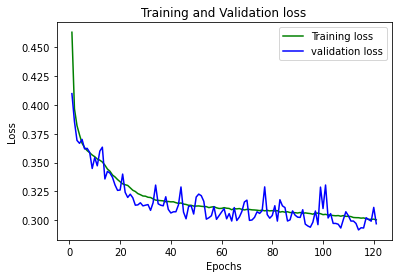

In [95]:
# Plotting the training and cross validation loss against number of epochs
loss_train = dic['loss']
loss_val = dic['val_loss']
epochs = range(1,122)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

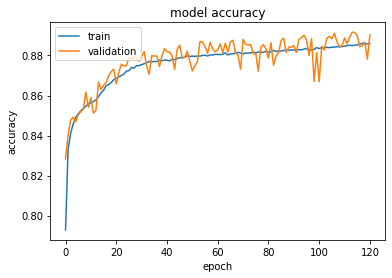

In [96]:
# Plotting the validation and training accuracy
plt.plot(dic['accuracy'])
plt.plot(dic['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [97]:
# Saving the model. This file has been attached with this notebook
model.save('/content/drive/MyDrive/IBM_model1')

In [98]:
# Saving the file history
hist_df = pd.DataFrame(dic) 

hist_csv_file = '/content/drive/MyDrive/model_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [99]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cv_predict = model.predict(cv_x).argmax(axis=-1)
cv_matrix = confusion_matrix(cv_y,cv_predict)
report = classification_report(cv_y,cv_predict)

2496/2496 [==============================] - 4s 2ms/step


In [100]:
print(cv_matrix)

[[57754  3236]
 [ 5518 13356]]


In [101]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     60990
           1       0.80      0.71      0.75     18874

    accuracy                           0.89     79864
   macro avg       0.86      0.83      0.84     79864
weighted avg       0.89      0.89      0.89     79864



In [102]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tr_predict = model.predict(train_x).argmax(axis=-1)
tr_matrix = confusion_matrix(train_y,tr_predict)
tr_report = classification_report(train_y,tr_predict)
print(tr_matrix)
print(tr_report)

11647/11647 [==============================] - 31s 3ms/step
[[269467  15153]
 [ 25893  62186]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    284620
           1       0.80      0.71      0.75     88079

    accuracy                           0.89    372699
   macro avg       0.86      0.83      0.84    372699
weighted avg       0.89      0.89      0.89    372699



In [106]:
test_x.shape

(79865, 25)

In [103]:
test_predict = model.predict(test_x).argmax(axis=-1)
test_matrix = confusion_matrix(test_y,test_predict)
test_report = classification_report(test_y,test_predict)
print(test_matrix)


2496/2496 [==============================] - 4s 2ms/step
[[57855  3136]
 [ 5476 13398]]


In [104]:
print(test_report)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     60991
           1       0.81      0.71      0.76     18874

    accuracy                           0.89     79865
   macro avg       0.86      0.83      0.84     79865
weighted avg       0.89      0.89      0.89     79865



In [105]:
print(accuracy_score(test_y,test_predict))

0.8921680335566268
